In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib
import os
import xgboost as xgb
import shap

from scripts.dataLoader import dataLoaderParallel

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# feature parameters
SIGNAL_FEATURE = ['mbp', 'sbp', 'dbp', 'hr', 'rr', 'spo2', 'etco2', 'mac', 'pp_ct', 'bis']
STATIC_FEATURE = ["age", "bmi", "asa", "preop_cr", "preop_htn"]
HALF_TIME_FILTERING = [10, 60, 5*60] # secondes

# model parameters
N_ESTIMATORS = np.logspace(1.5, 2.5, 3, dtype=int)
MAX_DEPTH = [3,5,7]
LEARNING_RATE = np.logspace(-2, -1, 2)
LAMBDA = 7
MIN_CHILD_WEIGHT = [3]
ROUND_NUMBER = 75
OBJECTIVE = ['binary:logistic']
METRIC = ['auc']

In [3]:
# test if raw file exists
if not os.path.exists('data/data_async.csv'):
    print('data_async.csv does not exist, please run dataset_download.py first')
    exit()
cols = list(pd.read_csv("data/data_async.csv", nrows=1))

rawData = pd.read_csv(f'data/data_async.csv', usecols =[i for i in cols if i != "opname"] ).astype("float32")


In [4]:

    
if not os.path.exists('data/data_xbg.csv'):
    dataframe = dataLoaderParallel(
        half_times= HALF_TIME_FILTERING,
        signal_name=SIGNAL_FEATURE,
        static_data=STATIC_FEATURE,
        max_number_of_case=5000,
        rawData= rawData,
        leading_time= 0,#3*60,
        prediction_windows=60*10
    )
    dataframe.to_csv('data/data_xbg.csv', index=False)
else:
    dataframe = pd.read_csv('data/data_xbg.csv')

Processing caseid: 100%|██████████| 2631/2631 [55:57<00:00,  1.28s/it]  


Number of raw segment: 1045881
Number of selected segment: 156588


In [5]:
# for each subgoup of data, create a regressor and evaluate it
from sklearn.metrics import auc, roc_curve, roc_auc_score
# import grid search
from sklearn.model_selection import GridSearchCV

tpr, fpr, auc  = [], [], []

FEATURE_NAME = [f'{signal}_ema_{half_time}' for signal in SIGNAL_FEATURE for half_time in HALF_TIME_FILTERING] + [f'{signal}_var_{half_time}' for signal in SIGNAL_FEATURE for half_time in HALF_TIME_FILTERING] + STATIC_FEATURE


for cv, test in dataframe.groupby('cv_group'):

    # create a regressor

    train = dataframe[dataframe['cv_group'] != cv]
    train = train.dropna(subset=FEATURE_NAME)
    test = test.dropna(subset=FEATURE_NAME)
    print(f'cv {cv} : {len(train)} train samples and {len(test)} test samples, positive rate = {test["label"].mean():.2f}')

    # try to open the model
    try:
        model = xgb.XGBClassifier()
        model.load_model(f'data/models/xgb_{cv}.json')
    except:

        model = xgb.XGBClassifier()

        param = {'n_estimators': N_ESTIMATORS,
                'max_depth': MAX_DEPTH,
                'learning_rate': LEARNING_RATE,
                'min_child_weight': MIN_CHILD_WEIGHT,
                'objective': OBJECTIVE,
                'eval_metric': METRIC,
                'nthread': [2]}
        
        num_round = ROUND_NUMBER

        # Grid search for tunning the model
        cd_search = GridSearchCV(model, param, cv=3, n_jobs=4, scoring='roc_auc', verbose=1)
        
        cd_search.fit(train[FEATURE_NAME], train['label'])
        print(cd_search.best_params_)
        print(cd_search.best_score_)

        #get xgboost model
        model = cd_search.best_estimator_

        #save the model
        model.save_model(f'data/models/xgb_{cv}.json')

    y_pred = model.predict_proba(test[FEATURE_NAME])[:, 1]
    y_test = test['label']

    fpr_, tpr_, _ = roc_curve(y_test, y_pred)
    tpr.append(tpr_)
    fpr.append(fpr_)

    auc.append(roc_auc_score(y_test, y_pred))


# compute mean ROC curve
fpr_mean = np.linspace(0, 1, 100)
tpr_mean = np.zeros(100)
tpr_std = np.zeros(100)
for j in range(len(fpr_mean)):
    tpr_mean[j] = np.mean([np.interp(fpr_mean[j], fpr[i], tpr[i]) for i in range(len(tpr))])
    tpr_std[j] = np.std([np.interp(fpr_mean[j], fpr[i], tpr[i]) for i in range(len(tpr))])

# save the ROC curve
df = pd.DataFrame({
    'fpr': fpr_mean,
    'tpr': tpr_mean,
    'tpr_std':tpr_std,
    'auc': np.mean(auc),
    'auc_std': pd.Series(auc).std()})
df.to_csv('data/xgboost_roc.csv', index=False)




cv 0 : 124897 train samples and 31691 test samples, positive rate = 0.07
Fitting 3 folds for each of 18 candidates, totalling 54 fits
{'eval_metric': 'auc', 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 316, 'nthread': 2, 'objective': 'binary:logistic'}
0.7953415807531018
cv 1 : 126637 train samples and 29951 test samples, positive rate = 0.07
Fitting 3 folds for each of 18 candidates, totalling 54 fits
{'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 31, 'nthread': 2, 'objective': 'binary:logistic'}
0.787809889275915
cv 2 : 128299 train samples and 28289 test samples, positive rate = 0.06
Fitting 3 folds for each of 18 candidates, totalling 54 fits
{'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'nthread': 2, 'objective': 'binary:logistic'}
0.7890688212093724
cv 3 : 124615 train samples and 31973 test samples, positive rate = 0.08
Fitting 3 folds 

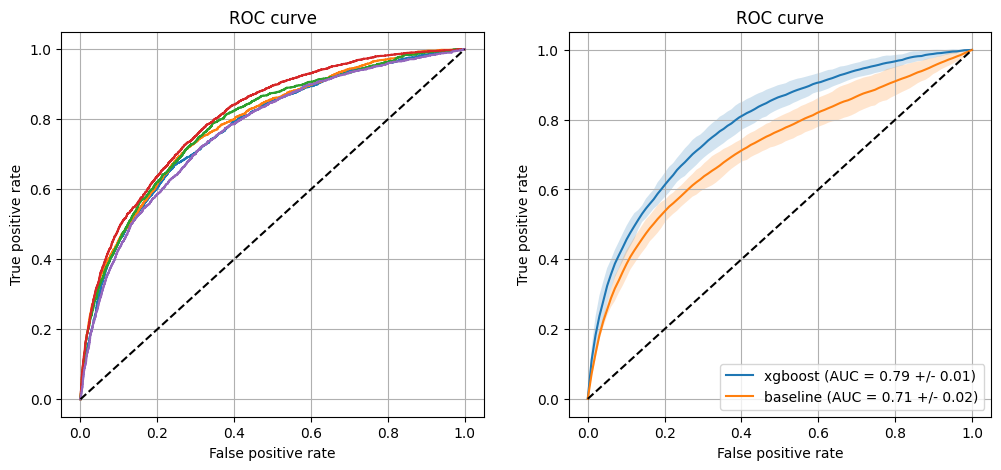

In [6]:

# plot the ROC curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i in range(len(tpr)):
    plt.plot(fpr[i], tpr[i], label=f'cv {i} (AUC = {auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.grid()

plt.subplot(1, 2, 2)
plt.fill_between(fpr_mean, tpr_mean - 2*tpr_std, tpr_mean + 2*tpr_std, alpha=0.2)
plt.plot(fpr_mean, tpr_mean, label=f'xgboost (AUC = {np.mean(auc):.2f} +/- {pd.Series(auc).std():.2f})')

#add baseline to the plot
df_baseline = pd.read_csv('data/baseline_roc.csv')
plt.fill_between(df_baseline.fpr, df_baseline.tpr - 2*df_baseline.tpr_std, df_baseline.tpr + 2*df_baseline.tpr_std, alpha=0.2)
plt.plot(df_baseline.fpr.values, df_baseline.tpr.values, label=f'baseline (AUC = {df_baseline.auc[0]:.2f} +/- {df_baseline.auc_std[0]:.2f})')


plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.grid()
plt.show()


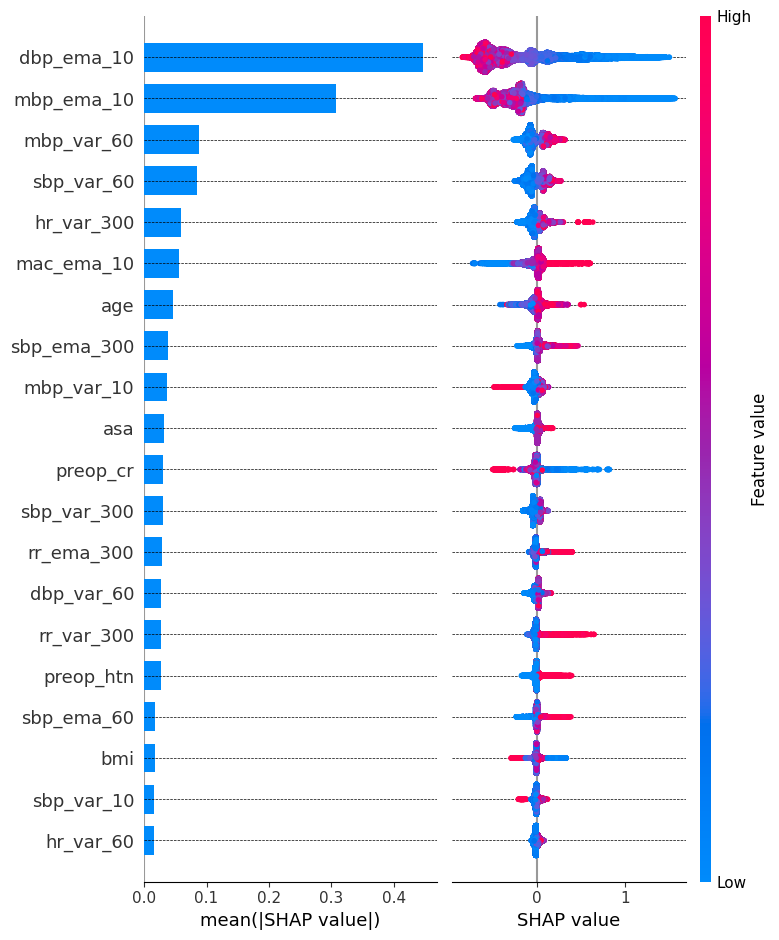

In [7]:
# use SHAP to explain the model
shap.initjs()
nb_max_feature = 20
shap_values_tot = []
test_data = pd.DataFrame()
for cv, test in dataframe.groupby('cv_group'):
    model = xgb.Booster()
    model.load_model(f'data/models/xgb_{cv}.json')
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(test[FEATURE_NAME])
    for shape in shap_values:
        shap_values_tot.append(shape)
    test_data= pd.concat([test_data, test[FEATURE_NAME]])

# plot the SHAP value
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i in range(nb_max_feature):
    plt.axhline(y=i, color='black', linestyle='--', linewidth=0.5)
shap.summary_plot(np.array(shap_values_tot), test_data, feature_names=FEATURE_NAME, show=False, plot_type="bar", max_display=nb_max_feature)
plt.xlabel('mean(|SHAP value|)')
plt.subplot(1, 2, 2)
shap.summary_plot(np.array(shap_values_tot), test_data, feature_names=FEATURE_NAME, show=False, max_display=nb_max_feature)
#remove the y thick label
plt.gca().set_yticklabels([])
plt.xlabel('SHAP value')
plt.tight_layout()
#add horizontal line for each feture
for i in range(nb_max_feature):
    plt.axhline(y=i, color='black', linestyle='--', linewidth=0.5)
plt.show()